In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
torch.manual_seed(76)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [3]:
# dataset prep
batch_size = 64

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

training_DataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testing_DataLoader= DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [4]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.Dense1 = nn.Linear(28*28, 128)
        self.Dense2 = nn.Linear(128, 64)
        self.Dense3 = nn.Linear(64, 32)
        self.Dense4 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.Dense1(x))
        x = F.relu(self.Dense2(x))
        x = F.relu(self.Dense3(x))
        x = self.Dense4(x)
        return x


In [5]:
def train(model, optimizer, epochs, train_loader):
    model.train()
    loss_func = torch.nn.CrossEntropyLoss()
    train_loss = []
    train_acc = []
    collected_weights_layer1 = []
    collected_weights_whole = []

    for epoch in tqdm(range(epochs)):
        correct = 0
        total_samples = 0
        batch_loss=[]
        batch_acc=[]

        for i, batch in enumerate(train_loader):
            images, labels = batch[0].to(device), batch[1].to(device)
            # Forward pass
            output = model(images)
            loss = loss_func(output, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            batch_loss.append(loss.item())
            batch_acc.append(correct/total_samples)

        if (epoch + 1) % 3 == 0:
            with torch.no_grad():
                layer1_weights = np.zeros(0)
                whole_weights = np.zeros(0)
                for name, param in model.named_parameters():
                    if 'weight' in name:
                        whole_weights = np.concatenate((whole_weights, param.detach().cpu().numpy().reshape(-1)))
                        if 'Dense1' in name:
                            layer1_weights = np.concatenate((layer1_weights, param.detach().cpu().numpy().reshape(-1)))
            collected_weights_layer1.append(layer1_weights)
            collected_weights_whole.append(whole_weights)

        # Calculate average loss and accuracy for the epoch
        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss[-1]:.4f}, Accuracy: {train_acc[-1] * 100:.2f}%')

    return train_loss, train_acc, collected_weights_layer1, collected_weights_whole

In [6]:
def apply_pca(weights):
    w = np.array(weights)
    print(w.shape)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(w)
    return pca_result

In [7]:
epoch = 24
layer_1_pca = []
whole_pca = []
train_acc_arr = []
train_loss_arr = []
for i in range(8):
    print(f" Train - {i+1}")
    model = DNNModel().to(device)
    optimizer1 = optim.Adam(model.parameters(), lr=1e-4)
    train_loss, train_acc, layer1_weights, whole_weights = train(model, optimizer1, epoch, training_DataLoader)
    pca_out_layer1 = apply_pca(layer1_weights)
    pca_out_whole = apply_pca(whole_weights)
    layer_1_pca.append(pca_out_layer1)
    whole_pca.append(pca_out_whole)
    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)

 Train - 1


  4%|▍         | 1/24 [00:17<06:53, 18.00s/it]

Epoch 1/24, Loss: 0.7637, Accuracy: 61.90%


  8%|▊         | 2/24 [00:32<05:50, 15.91s/it]

Epoch 2/24, Loss: 0.2910, Accuracy: 90.78%


 12%|█▎        | 3/24 [00:47<05:21, 15.33s/it]

Epoch 3/24, Loss: 0.2300, Accuracy: 92.95%


 17%|█▋        | 4/24 [01:01<05:00, 15.00s/it]

Epoch 4/24, Loss: 0.1938, Accuracy: 94.28%


 21%|██        | 5/24 [01:16<04:41, 14.83s/it]

Epoch 5/24, Loss: 0.1686, Accuracy: 94.92%


 25%|██▌       | 6/24 [01:30<04:25, 14.73s/it]

Epoch 6/24, Loss: 0.1487, Accuracy: 95.63%


 29%|██▉       | 7/24 [01:45<04:09, 14.70s/it]

Epoch 7/24, Loss: 0.1327, Accuracy: 96.07%


 33%|███▎      | 8/24 [01:59<03:55, 14.69s/it]

Epoch 8/24, Loss: 0.1197, Accuracy: 96.41%


 38%|███▊      | 9/24 [02:14<03:40, 14.67s/it]

Epoch 9/24, Loss: 0.1084, Accuracy: 96.61%


 42%|████▏     | 10/24 [02:29<03:25, 14.66s/it]

Epoch 10/24, Loss: 0.0989, Accuracy: 97.06%


 46%|████▌     | 11/24 [02:43<03:10, 14.66s/it]

Epoch 11/24, Loss: 0.0905, Accuracy: 97.41%


 50%|█████     | 12/24 [02:58<02:55, 14.66s/it]

Epoch 12/24, Loss: 0.0834, Accuracy: 97.57%


 54%|█████▍    | 13/24 [03:13<02:40, 14.61s/it]

Epoch 13/24, Loss: 0.0768, Accuracy: 97.75%


 58%|█████▊    | 14/24 [03:27<02:25, 14.59s/it]

Epoch 14/24, Loss: 0.0704, Accuracy: 98.03%


 62%|██████▎   | 15/24 [03:42<02:11, 14.56s/it]

Epoch 15/24, Loss: 0.0655, Accuracy: 98.13%


 67%|██████▋   | 16/24 [03:56<01:56, 14.58s/it]

Epoch 16/24, Loss: 0.0605, Accuracy: 98.19%


 71%|███████   | 17/24 [04:11<01:43, 14.76s/it]

Epoch 17/24, Loss: 0.0561, Accuracy: 98.34%


 75%|███████▌  | 18/24 [04:28<01:32, 15.42s/it]

Epoch 18/24, Loss: 0.0515, Accuracy: 98.51%


 79%|███████▉  | 19/24 [04:43<01:16, 15.26s/it]

Epoch 19/24, Loss: 0.0478, Accuracy: 98.67%


 83%|████████▎ | 20/24 [05:01<01:03, 15.94s/it]

Epoch 20/24, Loss: 0.0445, Accuracy: 98.79%


 88%|████████▊ | 21/24 [05:15<00:46, 15.51s/it]

Epoch 21/24, Loss: 0.0408, Accuracy: 98.87%


 92%|█████████▏| 22/24 [05:30<00:30, 15.22s/it]

Epoch 22/24, Loss: 0.0382, Accuracy: 99.01%


 96%|█████████▌| 23/24 [05:44<00:15, 15.01s/it]

Epoch 23/24, Loss: 0.0352, Accuracy: 99.04%


100%|██████████| 24/24 [05:59<00:00, 14.98s/it]

Epoch 24/24, Loss: 0.0325, Accuracy: 99.12%
(8, 100352)
(8, 110912)


 Train - 2


  4%|▍         | 1/24 [00:16<06:26, 16.79s/it]

Epoch 1/24, Loss: 0.7473, Accuracy: 61.40%


  8%|▊         | 2/24 [00:31<05:41, 15.50s/it]

Epoch 2/24, Loss: 0.2810, Accuracy: 91.29%


 12%|█▎        | 3/24 [00:46<05:17, 15.10s/it]

Epoch 3/24, Loss: 0.2291, Accuracy: 93.09%


 17%|█▋        | 4/24 [01:00<04:58, 14.93s/it]

Epoch 4/24, Loss: 0.1989, Accuracy: 94.16%


 21%|██        | 5/24 [01:15<04:41, 14.81s/it]

Epoch 5/24, Loss: 0.1767, Accuracy: 94.85%


 25%|██▌       | 6/24 [01:29<04:24, 14.72s/it]

Epoch 6/24, Loss: 0.1591, Accuracy: 95.38%


 29%|██▉       | 7/24 [01:44<04:08, 14.65s/it]

Epoch 7/24, Loss: 0.1444, Accuracy: 95.77%


 33%|███▎      | 8/24 [01:58<03:54, 14.63s/it]

Epoch 8/24, Loss: 0.1313, Accuracy: 96.00%


 38%|███▊      | 9/24 [02:13<03:38, 14.59s/it]

Epoch 9/24, Loss: 0.1200, Accuracy: 96.49%


 42%|████▏     | 10/24 [02:27<03:23, 14.55s/it]

Epoch 10/24, Loss: 0.1100, Accuracy: 96.84%


 46%|████▌     | 11/24 [02:42<03:09, 14.58s/it]

Epoch 11/24, Loss: 0.1016, Accuracy: 97.09%


 50%|█████     | 12/24 [02:57<02:55, 14.61s/it]

Epoch 12/24, Loss: 0.0932, Accuracy: 97.22%


 54%|█████▍    | 13/24 [03:11<02:40, 14.56s/it]

Epoch 13/24, Loss: 0.0864, Accuracy: 97.52%


 58%|█████▊    | 14/24 [03:26<02:25, 14.54s/it]

Epoch 14/24, Loss: 0.0798, Accuracy: 97.49%


 62%|██████▎   | 15/24 [03:40<02:11, 14.59s/it]

Epoch 15/24, Loss: 0.0740, Accuracy: 97.86%


 67%|██████▋   | 16/24 [03:55<01:56, 14.59s/it]

Epoch 16/24, Loss: 0.0684, Accuracy: 98.05%


 71%|███████   | 17/24 [04:10<01:42, 14.62s/it]

Epoch 17/24, Loss: 0.0633, Accuracy: 98.30%


 75%|███████▌  | 18/24 [04:24<01:27, 14.64s/it]

Epoch 18/24, Loss: 0.0594, Accuracy: 98.27%


 79%|███████▉  | 19/24 [04:39<01:13, 14.62s/it]

Epoch 19/24, Loss: 0.0557, Accuracy: 98.50%


 83%|████████▎ | 20/24 [04:53<00:58, 14.58s/it]

Epoch 20/24, Loss: 0.0510, Accuracy: 98.65%


 88%|████████▊ | 21/24 [05:08<00:43, 14.58s/it]

Epoch 21/24, Loss: 0.0476, Accuracy: 98.67%


 92%|█████████▏| 22/24 [05:23<00:29, 14.60s/it]

Epoch 22/24, Loss: 0.0444, Accuracy: 98.74%


 96%|█████████▌| 23/24 [05:37<00:14, 14.62s/it]

Epoch 23/24, Loss: 0.0417, Accuracy: 98.89%


100%|██████████| 24/24 [05:52<00:00, 14.68s/it]


Epoch 24/24, Loss: 0.0386, Accuracy: 99.03%
(8, 100352)
(8, 110912)
 Train - 3


  4%|▍         | 1/24 [00:14<05:36, 14.62s/it]

Epoch 1/24, Loss: 0.8011, Accuracy: 57.24%


  8%|▊         | 2/24 [00:29<05:21, 14.59s/it]

Epoch 2/24, Loss: 0.3068, Accuracy: 90.68%


 12%|█▎        | 3/24 [00:43<05:05, 14.54s/it]

Epoch 3/24, Loss: 0.2539, Accuracy: 92.49%


 17%|█▋        | 4/24 [01:00<05:12, 15.60s/it]

Epoch 4/24, Loss: 0.2197, Accuracy: 93.21%


 21%|██        | 5/24 [01:15<04:47, 15.13s/it]

Epoch 5/24, Loss: 0.1927, Accuracy: 94.11%


 25%|██▌       | 6/24 [01:29<04:27, 14.84s/it]

Epoch 6/24, Loss: 0.1700, Accuracy: 95.06%


 29%|██▉       | 7/24 [01:43<04:09, 14.69s/it]

Epoch 7/24, Loss: 0.1518, Accuracy: 95.48%


 33%|███▎      | 8/24 [01:58<03:53, 14.61s/it]

Epoch 8/24, Loss: 0.1366, Accuracy: 95.91%


 38%|███▊      | 9/24 [02:12<03:37, 14.51s/it]

Epoch 9/24, Loss: 0.1232, Accuracy: 96.32%


 42%|████▏     | 10/24 [02:26<03:22, 14.46s/it]

Epoch 10/24, Loss: 0.1124, Accuracy: 96.72%


 46%|████▌     | 11/24 [02:41<03:07, 14.43s/it]

Epoch 11/24, Loss: 0.1021, Accuracy: 97.03%


 50%|█████     | 12/24 [02:55<02:53, 14.44s/it]

Epoch 12/24, Loss: 0.0935, Accuracy: 97.30%


 54%|█████▍    | 13/24 [03:10<02:38, 14.40s/it]

Epoch 13/24, Loss: 0.0859, Accuracy: 97.58%


 58%|█████▊    | 14/24 [03:24<02:23, 14.36s/it]

Epoch 14/24, Loss: 0.0787, Accuracy: 97.66%


 62%|██████▎   | 15/24 [03:38<02:09, 14.35s/it]

Epoch 15/24, Loss: 0.0730, Accuracy: 97.82%


 67%|██████▋   | 16/24 [03:52<01:54, 14.30s/it]

Epoch 16/24, Loss: 0.0675, Accuracy: 98.08%


 71%|███████   | 17/24 [04:07<01:40, 14.32s/it]

Epoch 17/24, Loss: 0.0629, Accuracy: 98.26%


 75%|███████▌  | 18/24 [04:21<01:25, 14.27s/it]

Epoch 18/24, Loss: 0.0580, Accuracy: 98.40%


 79%|███████▉  | 19/24 [04:35<01:11, 14.27s/it]

Epoch 19/24, Loss: 0.0536, Accuracy: 98.42%


 83%|████████▎ | 20/24 [04:49<00:57, 14.26s/it]

Epoch 20/24, Loss: 0.0501, Accuracy: 98.62%


 88%|████████▊ | 21/24 [05:04<00:42, 14.31s/it]

Epoch 21/24, Loss: 0.0466, Accuracy: 98.71%


 92%|█████████▏| 22/24 [05:18<00:28, 14.33s/it]

Epoch 22/24, Loss: 0.0437, Accuracy: 98.75%


 96%|█████████▌| 23/24 [05:33<00:14, 14.38s/it]

Epoch 23/24, Loss: 0.0404, Accuracy: 98.87%


100%|██████████| 24/24 [05:47<00:00, 14.48s/it]


Epoch 24/24, Loss: 0.0374, Accuracy: 99.03%
(8, 100352)
(8, 110912)
 Train - 4


  4%|▍         | 1/24 [00:14<05:31, 14.42s/it]

Epoch 1/24, Loss: 0.7744, Accuracy: 62.88%


  8%|▊         | 2/24 [00:28<05:15, 14.34s/it]

Epoch 2/24, Loss: 0.3019, Accuracy: 90.80%


 12%|█▎        | 3/24 [00:43<05:01, 14.34s/it]

Epoch 3/24, Loss: 0.2465, Accuracy: 92.46%


 17%|█▋        | 4/24 [00:57<04:47, 14.38s/it]

Epoch 4/24, Loss: 0.2093, Accuracy: 93.68%


 21%|██        | 5/24 [01:11<04:32, 14.36s/it]

Epoch 5/24, Loss: 0.1804, Accuracy: 94.60%


 25%|██▌       | 6/24 [01:26<04:18, 14.37s/it]

Epoch 6/24, Loss: 0.1579, Accuracy: 95.25%


 29%|██▉       | 7/24 [01:40<04:04, 14.39s/it]

Epoch 7/24, Loss: 0.1392, Accuracy: 95.85%


 33%|███▎      | 8/24 [01:55<03:50, 14.40s/it]

Epoch 8/24, Loss: 0.1254, Accuracy: 96.37%


 38%|███▊      | 9/24 [02:09<03:36, 14.41s/it]

Epoch 9/24, Loss: 0.1126, Accuracy: 96.77%


 42%|████▏     | 10/24 [02:23<03:21, 14.41s/it]

Epoch 10/24, Loss: 0.1025, Accuracy: 96.92%


 46%|████▌     | 11/24 [02:39<03:11, 14.75s/it]

Epoch 11/24, Loss: 0.0931, Accuracy: 97.24%


 50%|█████     | 12/24 [02:53<02:55, 14.65s/it]

Epoch 12/24, Loss: 0.0854, Accuracy: 97.58%


 54%|█████▍    | 13/24 [03:08<02:40, 14.57s/it]

Epoch 13/24, Loss: 0.0787, Accuracy: 97.71%


 58%|█████▊    | 14/24 [03:22<02:24, 14.49s/it]

Epoch 14/24, Loss: 0.0724, Accuracy: 97.95%


 62%|██████▎   | 15/24 [03:36<02:09, 14.44s/it]

Epoch 15/24, Loss: 0.0671, Accuracy: 97.93%


 67%|██████▋   | 16/24 [03:51<01:55, 14.40s/it]

Epoch 16/24, Loss: 0.0621, Accuracy: 98.13%


 71%|███████   | 17/24 [04:05<01:40, 14.37s/it]

Epoch 17/24, Loss: 0.0580, Accuracy: 98.34%


 75%|███████▌  | 18/24 [04:19<01:26, 14.36s/it]

Epoch 18/24, Loss: 0.0540, Accuracy: 98.49%


 79%|███████▉  | 19/24 [04:34<01:11, 14.36s/it]

Epoch 19/24, Loss: 0.0498, Accuracy: 98.52%


 83%|████████▎ | 20/24 [04:48<00:57, 14.32s/it]

Epoch 20/24, Loss: 0.0468, Accuracy: 98.65%


 88%|████████▊ | 21/24 [05:02<00:42, 14.29s/it]

Epoch 21/24, Loss: 0.0436, Accuracy: 98.88%


 92%|█████████▏| 22/24 [05:16<00:28, 14.27s/it]

Epoch 22/24, Loss: 0.0406, Accuracy: 98.89%


 96%|█████████▌| 23/24 [05:31<00:14, 14.27s/it]

Epoch 23/24, Loss: 0.0375, Accuracy: 99.09%


100%|██████████| 24/24 [05:45<00:00, 14.39s/it]


Epoch 24/24, Loss: 0.0348, Accuracy: 99.00%
(8, 100352)
(8, 110912)
 Train - 5


  4%|▍         | 1/24 [00:14<05:27, 14.25s/it]

Epoch 1/24, Loss: 0.7152, Accuracy: 66.65%


  8%|▊         | 2/24 [00:28<05:13, 14.24s/it]

Epoch 2/24, Loss: 0.2790, Accuracy: 91.29%


 12%|█▎        | 3/24 [00:42<04:59, 14.28s/it]

Epoch 3/24, Loss: 0.2299, Accuracy: 92.95%


 17%|█▋        | 4/24 [00:59<05:03, 15.16s/it]

Epoch 4/24, Loss: 0.1989, Accuracy: 94.02%


 21%|██        | 5/24 [01:13<04:41, 14.82s/it]

Epoch 5/24, Loss: 0.1764, Accuracy: 94.95%


 25%|██▌       | 6/24 [01:27<04:23, 14.65s/it]

Epoch 6/24, Loss: 0.1590, Accuracy: 95.29%


 29%|██▉       | 7/24 [01:41<04:06, 14.48s/it]

Epoch 7/24, Loss: 0.1448, Accuracy: 95.63%


 33%|███▎      | 8/24 [01:56<03:50, 14.39s/it]

Epoch 8/24, Loss: 0.1322, Accuracy: 96.17%


 38%|███▊      | 9/24 [02:13<03:47, 15.17s/it]

Epoch 9/24, Loss: 0.1210, Accuracy: 96.43%


 42%|████▏     | 10/24 [02:27<03:28, 14.88s/it]

Epoch 10/24, Loss: 0.1114, Accuracy: 96.71%


 46%|████▌     | 11/24 [02:41<03:10, 14.68s/it]

Epoch 11/24, Loss: 0.1032, Accuracy: 97.02%


 50%|█████     | 12/24 [02:55<02:54, 14.56s/it]

Epoch 12/24, Loss: 0.0949, Accuracy: 97.18%


 54%|█████▍    | 13/24 [03:10<02:39, 14.47s/it]

Epoch 13/24, Loss: 0.0883, Accuracy: 97.44%


 58%|█████▊    | 14/24 [03:24<02:24, 14.41s/it]

Epoch 14/24, Loss: 0.0814, Accuracy: 97.72%


 62%|██████▎   | 15/24 [03:38<02:08, 14.31s/it]

Epoch 15/24, Loss: 0.0756, Accuracy: 97.73%


 67%|██████▋   | 16/24 [03:52<01:54, 14.27s/it]

Epoch 16/24, Loss: 0.0697, Accuracy: 97.99%


 71%|███████   | 17/24 [04:06<01:39, 14.24s/it]

Epoch 17/24, Loss: 0.0653, Accuracy: 98.10%


 75%|███████▌  | 18/24 [04:21<01:25, 14.24s/it]

Epoch 18/24, Loss: 0.0607, Accuracy: 98.17%


 79%|███████▉  | 19/24 [04:35<01:11, 14.21s/it]

Epoch 19/24, Loss: 0.0562, Accuracy: 98.52%


 83%|████████▎ | 20/24 [04:52<01:00, 15.05s/it]

Epoch 20/24, Loss: 0.0521, Accuracy: 98.56%


 88%|████████▊ | 21/24 [05:09<00:46, 15.66s/it]

Epoch 21/24, Loss: 0.0488, Accuracy: 98.67%


 92%|█████████▏| 22/24 [05:26<00:32, 16.09s/it]

Epoch 22/24, Loss: 0.0458, Accuracy: 98.63%


 96%|█████████▌| 23/24 [05:43<00:16, 16.39s/it]

Epoch 23/24, Loss: 0.0421, Accuracy: 98.87%


100%|██████████| 24/24 [06:00<00:00, 15.02s/it]


Epoch 24/24, Loss: 0.0390, Accuracy: 98.92%
(8, 100352)
(8, 110912)
 Train - 6


  4%|▍         | 1/24 [00:17<06:32, 17.08s/it]

Epoch 1/24, Loss: 0.7356, Accuracy: 65.67%


  8%|▊         | 2/24 [00:34<06:15, 17.09s/it]

Epoch 2/24, Loss: 0.2924, Accuracy: 91.07%


 12%|█▎        | 3/24 [00:51<05:57, 17.03s/it]

Epoch 3/24, Loss: 0.2419, Accuracy: 92.68%


 17%|█▋        | 4/24 [01:05<05:17, 15.88s/it]

Epoch 4/24, Loss: 0.2087, Accuracy: 93.99%


 21%|██        | 5/24 [01:21<05:07, 16.18s/it]

Epoch 5/24, Loss: 0.1838, Accuracy: 94.61%


 25%|██▌       | 6/24 [01:36<04:43, 15.76s/it]

Epoch 6/24, Loss: 0.1635, Accuracy: 95.28%


 29%|██▉       | 7/24 [01:51<04:18, 15.23s/it]

Epoch 7/24, Loss: 0.1473, Accuracy: 95.73%


 33%|███▎      | 8/24 [02:06<04:06, 15.41s/it]

Epoch 8/24, Loss: 0.1334, Accuracy: 95.96%


 38%|███▊      | 9/24 [02:20<03:45, 15.01s/it]

Epoch 9/24, Loss: 0.1221, Accuracy: 96.37%


 42%|████▏     | 10/24 [02:35<03:26, 14.72s/it]

Epoch 10/24, Loss: 0.1116, Accuracy: 96.53%


 46%|████▌     | 11/24 [02:49<03:12, 14.78s/it]

Epoch 11/24, Loss: 0.1034, Accuracy: 97.05%


 50%|█████     | 12/24 [03:04<02:55, 14.62s/it]

Epoch 12/24, Loss: 0.0949, Accuracy: 97.12%


 54%|█████▍    | 13/24 [03:18<02:39, 14.53s/it]

Epoch 13/24, Loss: 0.0882, Accuracy: 97.35%


 58%|█████▊    | 14/24 [03:32<02:24, 14.48s/it]

Epoch 14/24, Loss: 0.0820, Accuracy: 97.51%


 62%|██████▎   | 15/24 [03:47<02:09, 14.40s/it]

Epoch 15/24, Loss: 0.0759, Accuracy: 97.84%


 67%|██████▋   | 16/24 [04:01<01:54, 14.35s/it]

Epoch 16/24, Loss: 0.0707, Accuracy: 97.91%


 71%|███████   | 17/24 [04:18<01:45, 15.08s/it]

Epoch 17/24, Loss: 0.0664, Accuracy: 98.09%


 75%|███████▌  | 18/24 [04:32<01:29, 14.85s/it]

Epoch 18/24, Loss: 0.0609, Accuracy: 98.18%


 79%|███████▉  | 19/24 [04:46<01:13, 14.70s/it]

Epoch 19/24, Loss: 0.0575, Accuracy: 98.30%


 83%|████████▎ | 20/24 [05:01<00:58, 14.58s/it]

Epoch 20/24, Loss: 0.0535, Accuracy: 98.46%


 88%|████████▊ | 21/24 [05:15<00:43, 14.48s/it]

Epoch 21/24, Loss: 0.0503, Accuracy: 98.54%


 92%|█████████▏| 22/24 [05:29<00:28, 14.42s/it]

Epoch 22/24, Loss: 0.0460, Accuracy: 98.69%


 96%|█████████▌| 23/24 [05:43<00:14, 14.34s/it]

Epoch 23/24, Loss: 0.0434, Accuracy: 98.82%


100%|██████████| 24/24 [05:58<00:00, 14.92s/it]


Epoch 24/24, Loss: 0.0402, Accuracy: 98.80%
(8, 100352)
(8, 110912)
 Train - 7


  4%|▍         | 1/24 [00:14<05:26, 14.21s/it]

Epoch 1/24, Loss: 0.7401, Accuracy: 62.18%


  8%|▊         | 2/24 [00:28<05:13, 14.24s/it]

Epoch 2/24, Loss: 0.2831, Accuracy: 91.30%


 12%|█▎        | 3/24 [00:42<04:58, 14.22s/it]

Epoch 3/24, Loss: 0.2278, Accuracy: 92.86%


 17%|█▋        | 4/24 [00:56<04:44, 14.25s/it]

Epoch 4/24, Loss: 0.1934, Accuracy: 94.16%


 21%|██        | 5/24 [01:11<04:30, 14.22s/it]

Epoch 5/24, Loss: 0.1684, Accuracy: 94.83%


 25%|██▌       | 6/24 [01:25<04:14, 14.16s/it]

Epoch 6/24, Loss: 0.1500, Accuracy: 95.56%


 29%|██▉       | 7/24 [01:39<04:00, 14.14s/it]

Epoch 7/24, Loss: 0.1339, Accuracy: 96.07%


 33%|███▎      | 8/24 [01:53<03:46, 14.17s/it]

Epoch 8/24, Loss: 0.1209, Accuracy: 96.44%


 38%|███▊      | 9/24 [02:07<03:33, 14.20s/it]

Epoch 9/24, Loss: 0.1099, Accuracy: 96.79%


 42%|████▏     | 10/24 [02:22<03:19, 14.23s/it]

Epoch 10/24, Loss: 0.1007, Accuracy: 96.97%


 46%|████▌     | 11/24 [02:36<03:05, 14.26s/it]

Epoch 11/24, Loss: 0.0914, Accuracy: 97.26%


 50%|█████     | 12/24 [02:50<02:51, 14.27s/it]

Epoch 12/24, Loss: 0.0837, Accuracy: 97.51%


 54%|█████▍    | 13/24 [03:04<02:37, 14.28s/it]

Epoch 13/24, Loss: 0.0771, Accuracy: 97.77%


 58%|█████▊    | 14/24 [03:19<02:22, 14.28s/it]

Epoch 14/24, Loss: 0.0709, Accuracy: 97.96%


 62%|██████▎   | 15/24 [03:33<02:08, 14.24s/it]

Epoch 15/24, Loss: 0.0653, Accuracy: 98.04%


 67%|██████▋   | 16/24 [03:47<01:54, 14.26s/it]

Epoch 16/24, Loss: 0.0610, Accuracy: 98.20%


 71%|███████   | 17/24 [04:01<01:39, 14.25s/it]

Epoch 17/24, Loss: 0.0563, Accuracy: 98.41%


 75%|███████▌  | 18/24 [04:16<01:25, 14.21s/it]

Epoch 18/24, Loss: 0.0519, Accuracy: 98.56%


 79%|███████▉  | 19/24 [04:30<01:11, 14.21s/it]

Epoch 19/24, Loss: 0.0480, Accuracy: 98.61%


 83%|████████▎ | 20/24 [04:44<00:56, 14.22s/it]

Epoch 20/24, Loss: 0.0447, Accuracy: 98.81%


 88%|████████▊ | 21/24 [04:59<00:42, 14.33s/it]

Epoch 21/24, Loss: 0.0414, Accuracy: 98.94%


 92%|█████████▏| 22/24 [05:13<00:28, 14.28s/it]

Epoch 22/24, Loss: 0.0381, Accuracy: 98.96%


 96%|█████████▌| 23/24 [05:27<00:14, 14.23s/it]

Epoch 23/24, Loss: 0.0352, Accuracy: 99.11%


100%|██████████| 24/24 [05:41<00:00, 14.23s/it]


Epoch 24/24, Loss: 0.0328, Accuracy: 99.10%
(8, 100352)
(8, 110912)
 Train - 8


  4%|▍         | 1/24 [00:14<05:24, 14.12s/it]

Epoch 1/24, Loss: 0.7642, Accuracy: 64.58%


  8%|▊         | 2/24 [00:28<05:09, 14.08s/it]

Epoch 2/24, Loss: 0.2980, Accuracy: 90.89%


 12%|█▎        | 3/24 [00:42<04:56, 14.14s/it]

Epoch 3/24, Loss: 0.2382, Accuracy: 92.76%


 17%|█▋        | 4/24 [00:56<04:44, 14.22s/it]

Epoch 4/24, Loss: 0.2006, Accuracy: 93.83%


 21%|██        | 5/24 [01:13<04:49, 15.26s/it]

Epoch 5/24, Loss: 0.1737, Accuracy: 94.87%


 25%|██▌       | 6/24 [01:29<04:39, 15.55s/it]

Epoch 6/24, Loss: 0.1531, Accuracy: 95.48%


 29%|██▉       | 7/24 [01:44<04:16, 15.09s/it]

Epoch 7/24, Loss: 0.1367, Accuracy: 96.11%


 33%|███▎      | 8/24 [01:58<03:56, 14.77s/it]

Epoch 8/24, Loss: 0.1234, Accuracy: 96.43%


 38%|███▊      | 9/24 [02:12<03:38, 14.56s/it]

Epoch 9/24, Loss: 0.1123, Accuracy: 96.64%


 42%|████▏     | 10/24 [02:26<03:21, 14.42s/it]

Epoch 10/24, Loss: 0.1027, Accuracy: 96.99%


 46%|████▌     | 11/24 [02:41<03:09, 14.56s/it]

Epoch 11/24, Loss: 0.0943, Accuracy: 97.20%


 50%|█████     | 12/24 [02:56<02:57, 14.79s/it]

Epoch 12/24, Loss: 0.0874, Accuracy: 97.40%


 54%|█████▍    | 13/24 [03:10<02:40, 14.60s/it]

Epoch 13/24, Loss: 0.0808, Accuracy: 97.71%


 58%|█████▊    | 14/24 [03:24<02:24, 14.46s/it]

Epoch 14/24, Loss: 0.0747, Accuracy: 97.85%


 62%|██████▎   | 15/24 [03:39<02:10, 14.48s/it]

Epoch 15/24, Loss: 0.0698, Accuracy: 97.97%


 67%|██████▋   | 16/24 [03:54<01:56, 14.57s/it]

Epoch 16/24, Loss: 0.0647, Accuracy: 98.20%


 71%|███████   | 17/24 [04:08<01:41, 14.43s/it]

Epoch 17/24, Loss: 0.0603, Accuracy: 98.31%


 75%|███████▌  | 18/24 [04:22<01:26, 14.34s/it]

Epoch 18/24, Loss: 0.0563, Accuracy: 98.44%


 79%|███████▉  | 19/24 [04:36<01:11, 14.34s/it]

Epoch 19/24, Loss: 0.0529, Accuracy: 98.42%


 83%|████████▎ | 20/24 [04:53<01:00, 15.19s/it]

Epoch 20/24, Loss: 0.0493, Accuracy: 98.64%


 88%|████████▊ | 21/24 [05:08<00:44, 14.89s/it]

Epoch 21/24, Loss: 0.0465, Accuracy: 98.76%


 92%|█████████▏| 22/24 [05:23<00:30, 15.16s/it]

Epoch 22/24, Loss: 0.0433, Accuracy: 98.92%


 96%|█████████▌| 23/24 [05:38<00:14, 14.97s/it]

Epoch 23/24, Loss: 0.0404, Accuracy: 98.97%


100%|██████████| 24/24 [05:52<00:00, 14.69s/it]

Epoch 24/24, Loss: 0.0378, Accuracy: 99.02%
(8, 100352)
(8, 110912)


In [9]:
layer_1_pca


[array([[ 4.31661176,  1.1765735 ],
        [ 2.79006118, -0.2337644 ],
        [ 1.32082741, -0.84423756],
        [ 0.05721453, -0.8478872 ],
        [-0.99741023, -0.52895365],
        [-1.84241596, -0.05541309],
        [-2.54652957,  0.43411743],
        [-3.09835912,  0.89956497]]),
 array([[ 4.26428045,  1.16719105],
        [ 2.82013075, -0.17720817],
        [ 1.3863834 , -0.80090959],
        [ 0.10684725, -0.87696077],
        [-0.98015246, -0.56934954],
        [-1.86843056, -0.08999732],
        [-2.57420641,  0.43177995],
        [-3.15485241,  0.9154544 ]]),
 array([[ 4.51342376,  1.24502619],
        [ 2.97051199, -0.23212522],
        [ 1.40936427, -0.89990535],
        [ 0.02980904, -0.92012842],
        [-1.07799643, -0.56574452],
        [-1.96100757, -0.06570152],
        [-2.65643886,  0.47347717],
        [-3.22766619,  0.96510168]]),
 array([[ 4.49985293,  1.23826933],
        [ 2.87948189, -0.27581265],
        [ 1.33127396, -0.90812501],
        [ 0.00739256, 

In [21]:
#visualize

def plot_weights(pca_layer, plot_name):
    fig = plt.figure(figsize=(15, 15))
    
    plt.xlabel('Weight PC1')
    plt.ylabel('Weight PC2')
    
    plt.title(plot_name)
    
    # Iterate over each PCA component
    for i in range(len(pca_layer)):
        W_i = pca_layer[i]
        
        # Scatter plot the weights along PC1 and PC2 axes
        plt.scatter(W_i[:, 0], W_i[:, 1])
    
    plt.show()


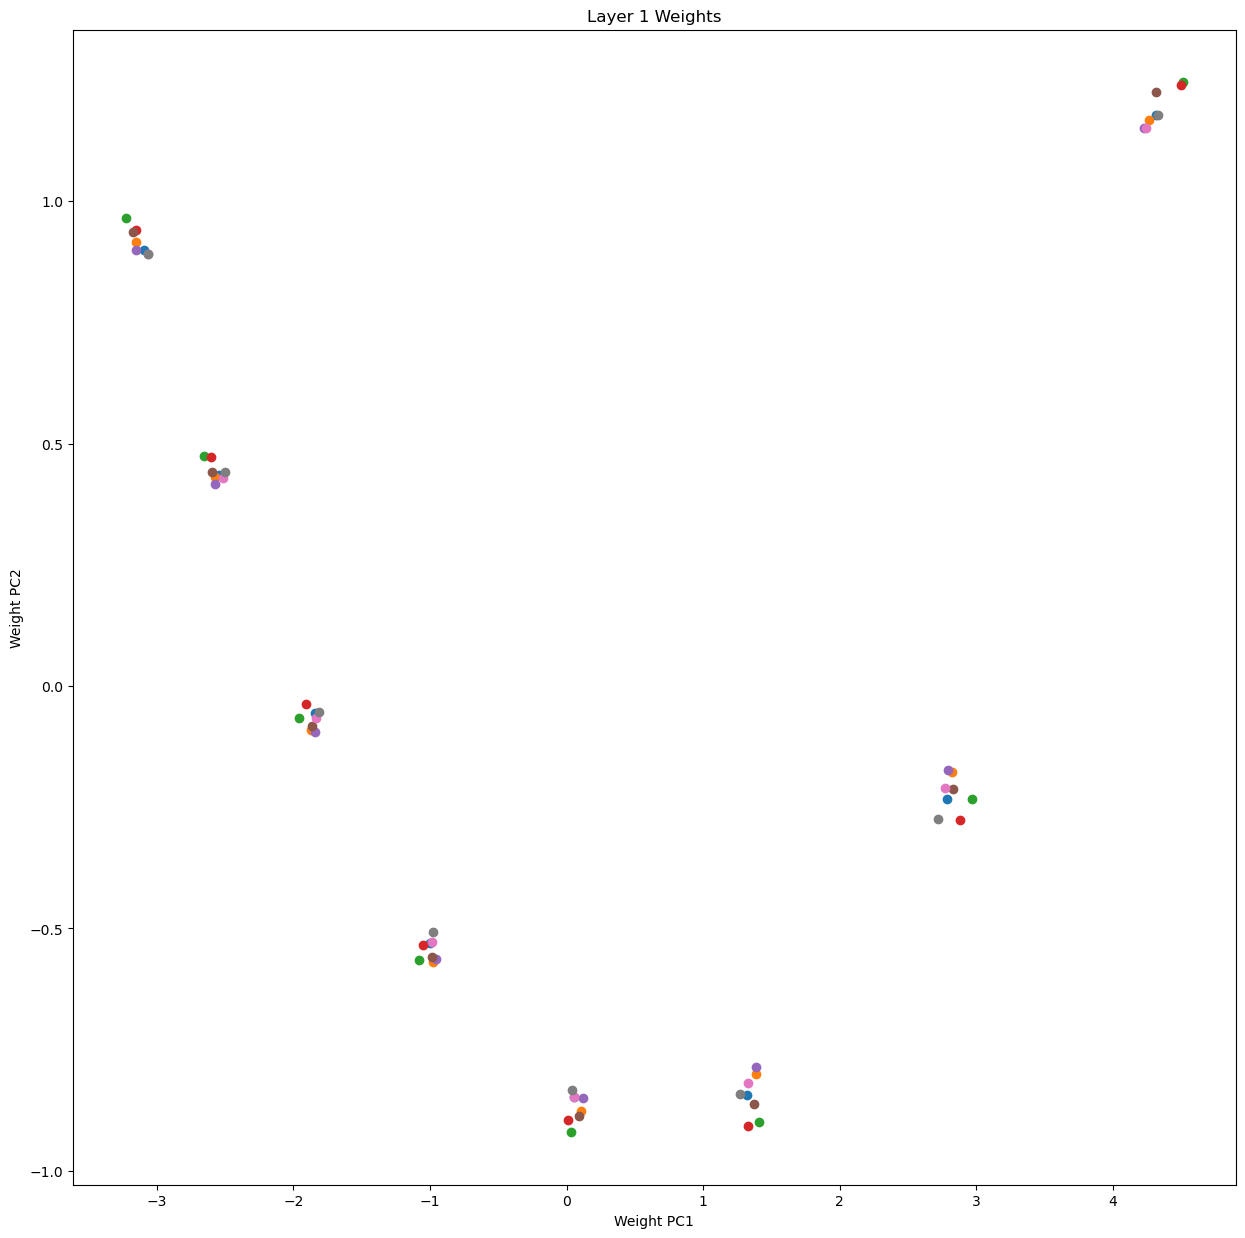

In [24]:
plot_weights(layer_1_pca, train_acc_arr, "Layer 1 Weights")

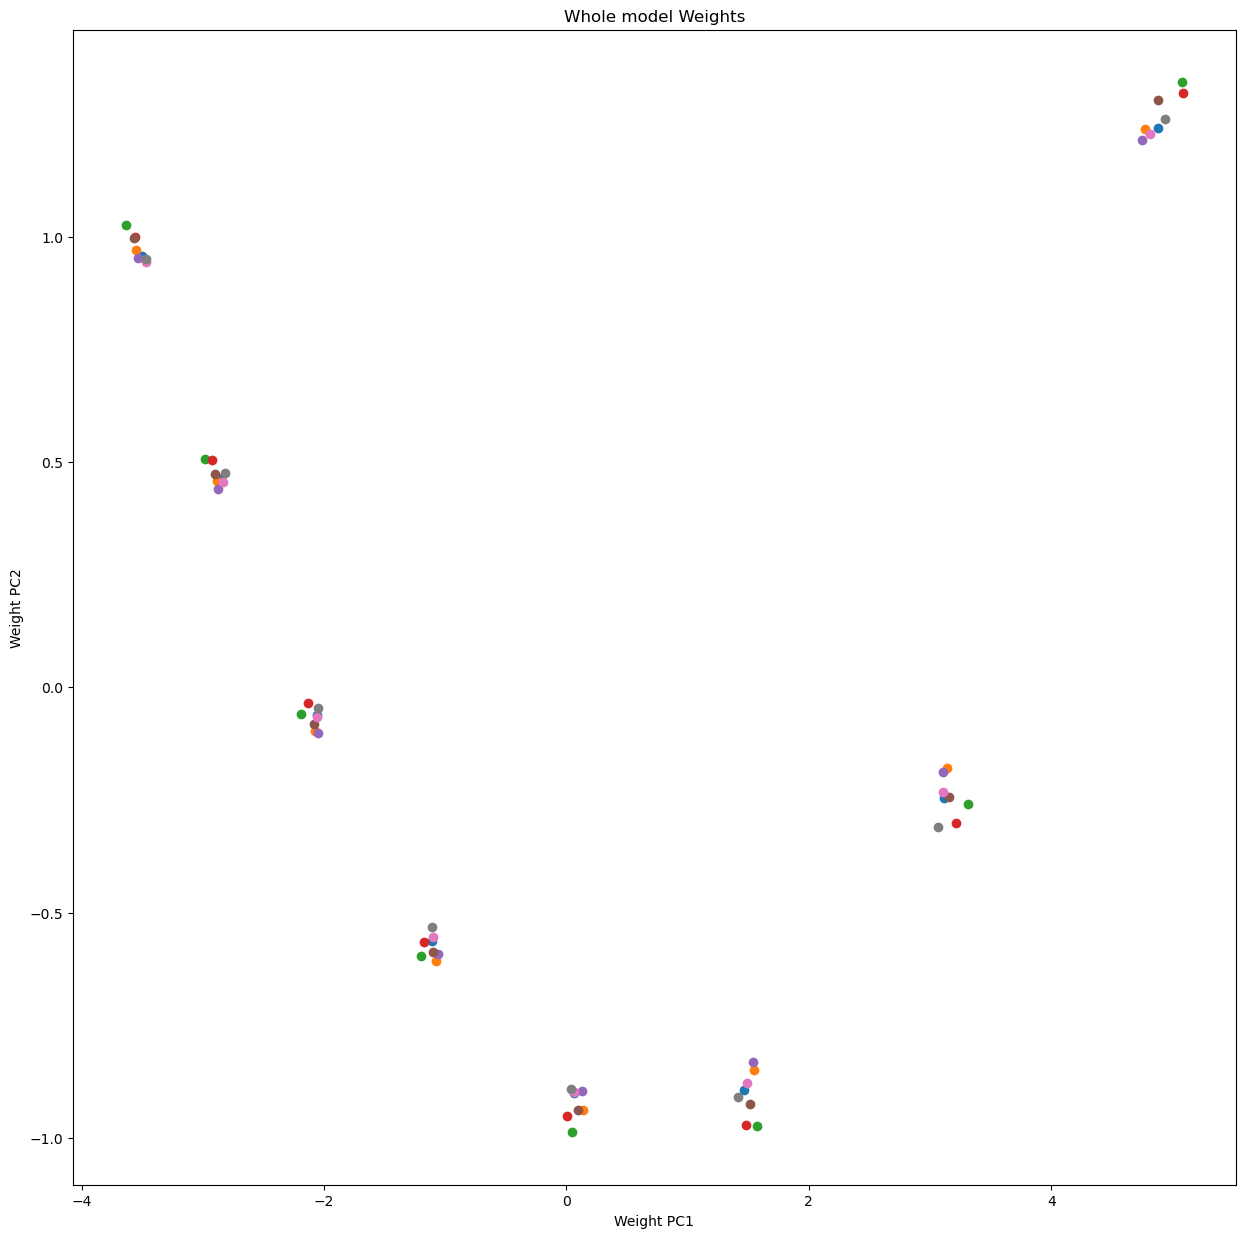

In [26]:
plot_weights(whole_pca, train_acc_arr, "Whole model Weights")

In [29]:
whole_pca

[array([[ 4.88279649,  1.23995062],
        [ 3.11679293, -0.24581886],
        [ 1.46512326, -0.89196513],
        [ 0.06290736, -0.89953554],
        [-1.10897143, -0.56217899],
        [-2.06005942, -0.06038927],
        [-2.85856299,  0.46321839],
        [-3.50002621,  0.95671877]]),
 array([[ 4.76897113,  1.23907277],
        [ 3.14044249, -0.17919048],
        [ 1.5484637 , -0.84805321],
        [ 0.13398655, -0.93659678],
        [-1.08031362, -0.60584953],
        [-2.07831144, -0.09677698],
        [-2.88202269,  0.45674574],
        [-3.55121611,  0.97064848]]),
 array([[ 5.07783262,  1.34218208],
        [ 3.30921645, -0.25842398],
        [ 1.57115433, -0.97301076],
        [ 0.04177691, -0.98661783],
        [-1.19726557, -0.59573203],
        [-2.18850762, -0.05976157],
        [-2.97890188,  0.50686918],
        [-3.63530523,  1.02449491]]),
 array([[ 5.08396375,  1.3191932 ],
        [ 3.21744102, -0.30062586],
        [ 1.48049707, -0.97133423],
        [ 0.00656445, 

In [30]:
layer_1_pca

[array([[ 4.31661176,  1.1765735 ],
        [ 2.79006118, -0.2337644 ],
        [ 1.32082741, -0.84423756],
        [ 0.05721453, -0.8478872 ],
        [-0.99741023, -0.52895365],
        [-1.84241596, -0.05541309],
        [-2.54652957,  0.43411743],
        [-3.09835912,  0.89956497]]),
 array([[ 4.26428045,  1.16719105],
        [ 2.82013075, -0.17720817],
        [ 1.3863834 , -0.80090959],
        [ 0.10684725, -0.87696077],
        [-0.98015246, -0.56934954],
        [-1.86843056, -0.08999732],
        [-2.57420641,  0.43177995],
        [-3.15485241,  0.9154544 ]]),
 array([[ 4.51342376,  1.24502619],
        [ 2.97051199, -0.23212522],
        [ 1.40936427, -0.89990535],
        [ 0.02980904, -0.92012842],
        [-1.07799643, -0.56574452],
        [-1.96100757, -0.06570152],
        [-2.65643886,  0.47347717],
        [-3.22766619,  0.96510168]]),
 array([[ 4.49985293,  1.23826933],
        [ 2.87948189, -0.27581265],
        [ 1.33127396, -0.90812501],
        [ 0.00739256, 